In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sun Dec 27 20:26:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 48%   80C    P2   248W / 250W |   3333MiB / 11019MiB |     92%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from model.efficiency import pv_locations, efficiency

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 20

# Name is the output file name


##  200719  mds
##folder = '20December_Tracks_to_KDE_TestTrainedModel'
##folder = '22December_testing_DDplus_loss_Bb_iter2_floatAll_100epochs_3em6'
folder = '22December_testing_DDplus_loss_Bb_realBb_iter0_floatAll_50epochs_1em4'
name = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 16
# How fast to learn
learning_rate = 3e-5

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
from model.collectdata_kde_Ellipsoids import collect_t2kde_data
from model.collectdata_mdsA  import collect_truth

# From model/loss.py
##from loss import Loss
##from model.kde_loss_D import Loss
from model.kde_loss_B import Loss


##from model.models_kde import TracksToKDE_Ellipsoids_DirtyDozen as Model
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as Model

from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
##device = select_gpu(0)
device = "cpu"

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:

                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
                            slice = slice(0,20)
                           )

PV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=True)
print('PV.n.shape =    ',  PV.n.shape)
print('PV.n[0].shape = ', *PV.n[0].shape)
print('PV.x[0] =       ', *PV.x[0])
print('PV.y[0] =       ', *PV.y[0])
print('PV.z[0] =       ', *PV.z[0])
print('PV.n[0] =       ', *PV.n[0])
print('PV.cat[0] =     ', *PV.cat[0])

SV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=False)
print('SV.n.shape =    ', SV.n.shape)
print('SV.n[0].shape = ', *SV.n[0].shape)
print('SV.x[0] =       ', *SV.x[0])
print('SV.y[0] =       ', *SV.y[0])
print('SV.z[0] =       ', *SV.z[0])
print('SV.n[0] =       ', *SV.n[0])
print('SV.cat[0] =     ', *SV.cat[0])


Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] = 

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=1e-5, debug=True)
loss = Loss(epsilon=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

In [11]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

Let's move the model's weight matricies to the GPU:

In [19]:
##print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
##pretrained_dict = torch.load('ML/Aug17_FourFeature_CNN6LayerPlus_TargetsAA_Loss_A_1p0_final.pyt')
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
'''
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]
'''
model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()

##print("updated model_dict = ",model_dict)

##  pretrained_dict = torch.load('ML/25October_testing_SevenLayerCake_first_learning_iter3_4000epochs_lossE_Adam/25October_testing_SevenLayerCake_first_learning_iter3_4000epochs_lossE_Adam_final.pyt')

##  pretrained_dict = torch.load('ML/27October_testing_DirtyDozen_first_learning_iter3_2500epochs_1em5/27October_testing_DirtyDozen_first_learning_iter3_2500epochs_1em5_final.pyt')

##folder = '20December_testing_DDplus_first_learning_10epochs_1em4'
## folder = '20December_testing_DDplus_iter1_20epochs_1em4'
##folder = '20December_testing_DDplus_iter2_floatAll_50epochs_1em4'
##folder = '20December_testing_DDplus_iter4_floatAll_200epochs_6em5'
##folder = '20December_testing_DDplus_loss_Ba_iter1_floatAll_100epochs_1em3'
##folder = '20December_testing_DDplus_loss_Ba_iter2_floatAll_700epochs_2em4'
folder = '21December_testing_DDplus_loss_Ba_iter4_floatAll_700epochs_5em6'
##folder = '20December_testing_DDplus_loss_Ba_iter2_floatAll_700epochs_5em5'
folder = '22December_testing_DDplus_loss_Bb_iter0_floatAll_20epochs_1em4'
folder = '22December_testing_DDplus_loss_Bb_iter1_floatAll_100epochs_1em5'
folder = '22December_testing_DDplus_loss_Bb_iter2_floatAll_100epochs_3em6'  ## final training cost 1.31031
##folder = '22December_testing_DDplus_loss_Bb_realBb_iter0A_floatAll_50epochs_1em5'
##folder = '22December_testing_DDplus_loss_Bb_realBb_iter2A_floatAll_100epochs_2em6'
##folder = '22December_testing_DDplus_loss_Bb__iter0c_floatAll_fromScratch_20epochs_1em3'
folder = '25December__DDplus_loss_Ba_iter4_floatAll_500epochs_1em5'
folder = '25December__DDplus_loss_Ba_iter5_floatAll_800epochs_1em5'
folder = '25December__DDplus_loss_Ba_iter5_floatAll_800epochs_5em6'  ## really iter6, really Dec. 27
folder = '25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6'
name = folder
suffix = 'final'
dict_name = 'ML/' + folder + '/' + name + '_'+ suffix + '.pyt'
print('dict_name = ',dict_name)
pretrained_dict = torch.load(dict_name)

print(" \n","  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 

##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12new.weight
index, k =   23    layer12new.bias
index, k =   24    conv1.weight
index, k =   25    conv1.bias
index, k =   26    conv2.weight
index, k =   27    conv2.bias
index, k =   28    fc1.weight
index, k =   29    fc1.bias
index, k =   30    finalFilter.we

<All keys matched successfully>

In [20]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [21]:
model = model.to(device)

val_loader =  <torch.utils.data.dataloader.DataLoader object at 0x7f832bd79710>
inputs.shape =  torch.Size([16, 9, 600])
outputs.shape =  torch.Size([16, 4000])
labels.shape =   torch.Size([16, 12000])
y.shape =  torch.Size([16, 4000, 3])
y_kde.shape =  (4000,)
event =  0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


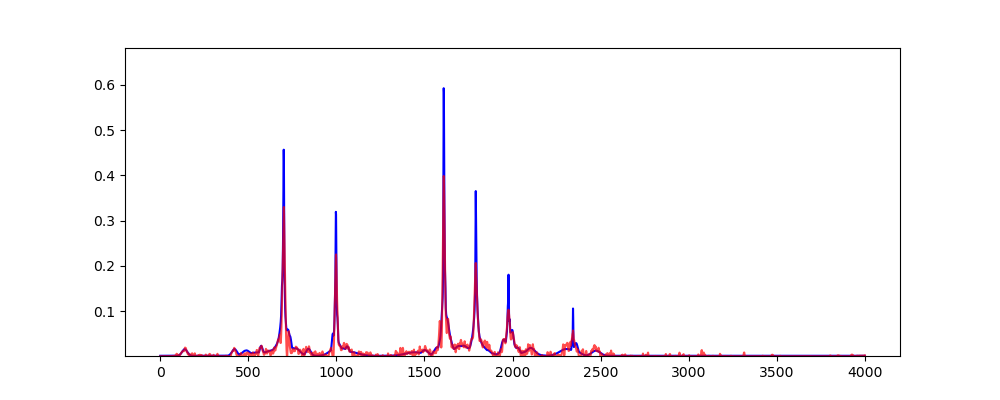

y_kde.shape =  (4000,)
event =  1


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


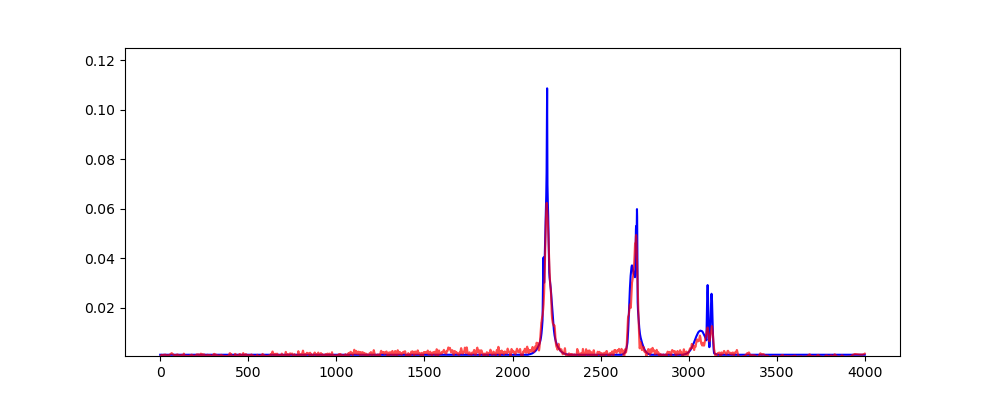

y_kde.shape =  (4000,)
event =  2


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


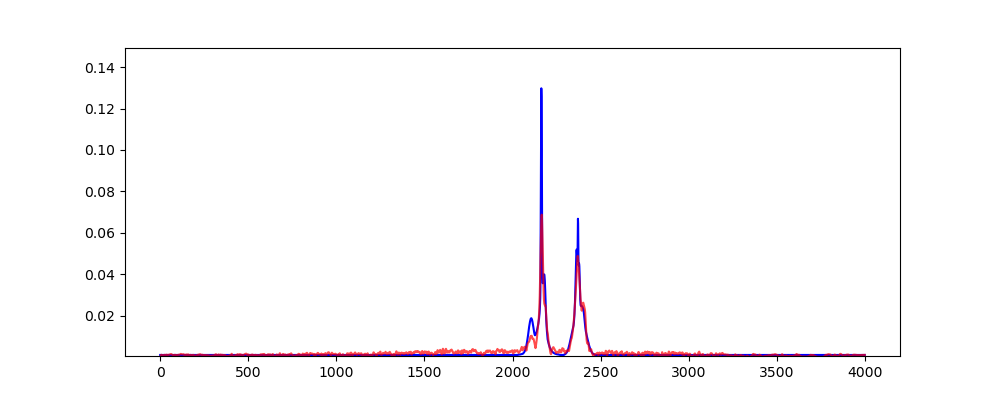

y_kde.shape =  (4000,)
event =  3


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


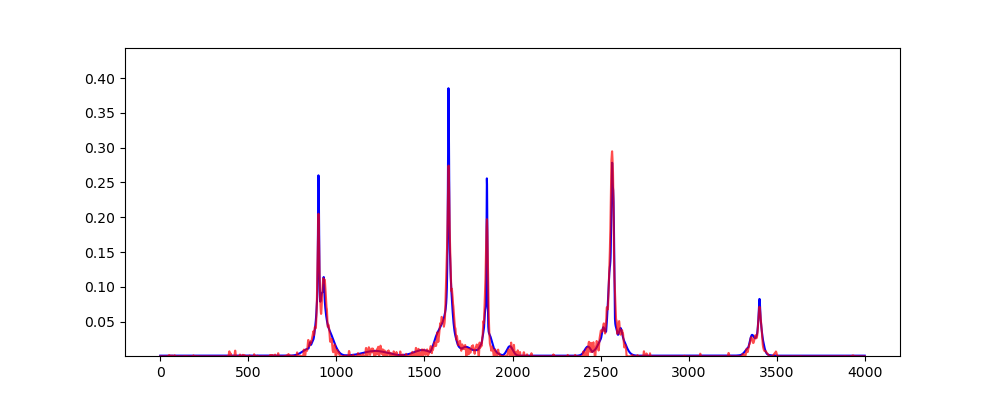

y_kde.shape =  (4000,)
event =  4


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


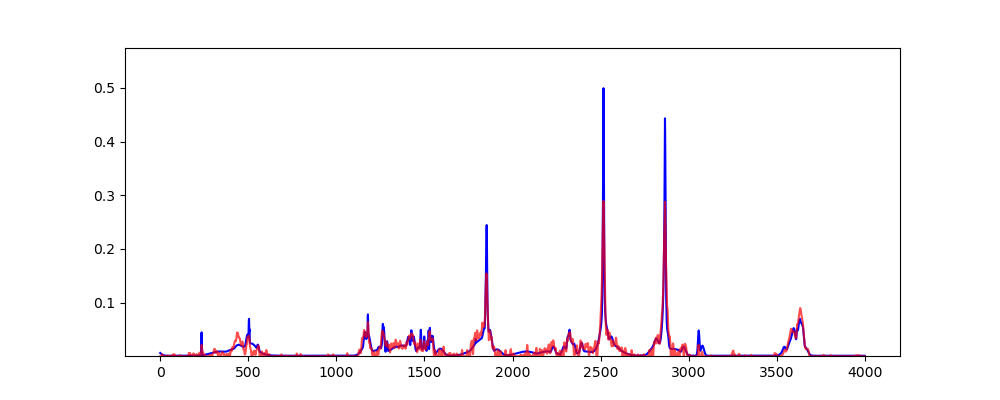

y_kde.shape =  (4000,)
event =  5


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


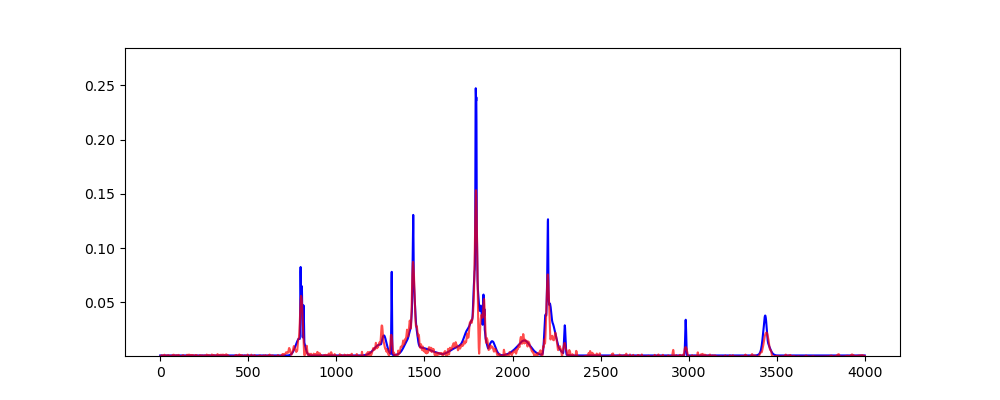

y_kde.shape =  (4000,)
event =  6


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


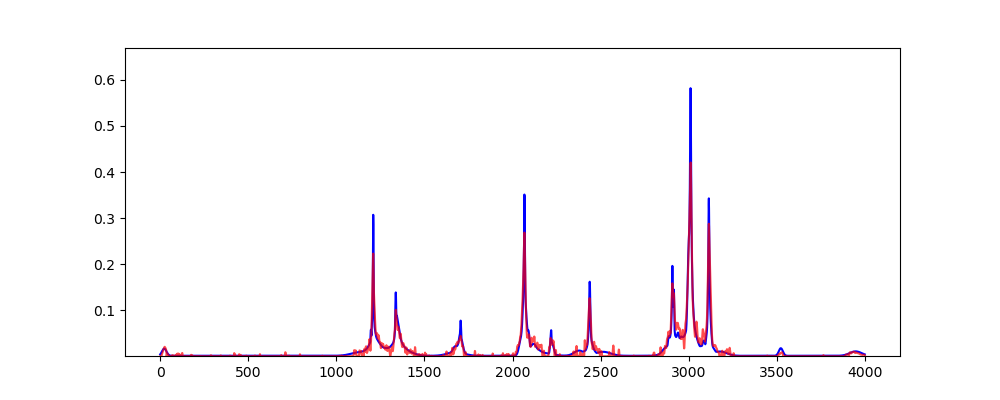

y_kde.shape =  (4000,)
event =  7


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


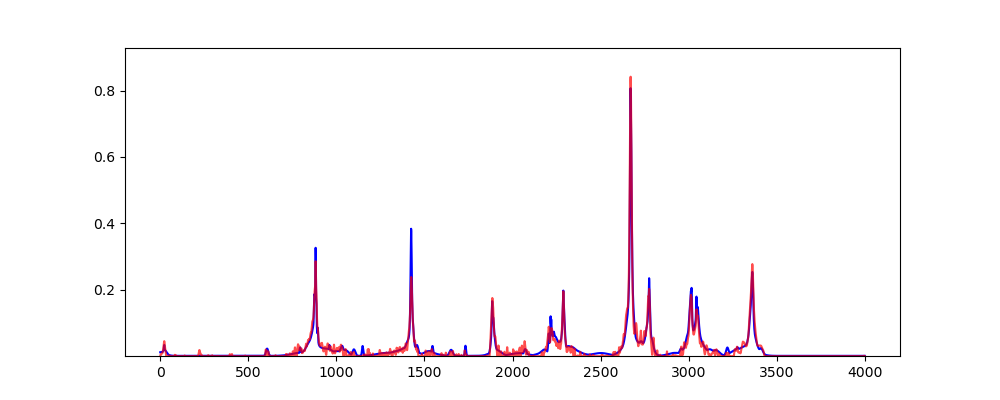

y_kde.shape =  (4000,)
event =  8


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


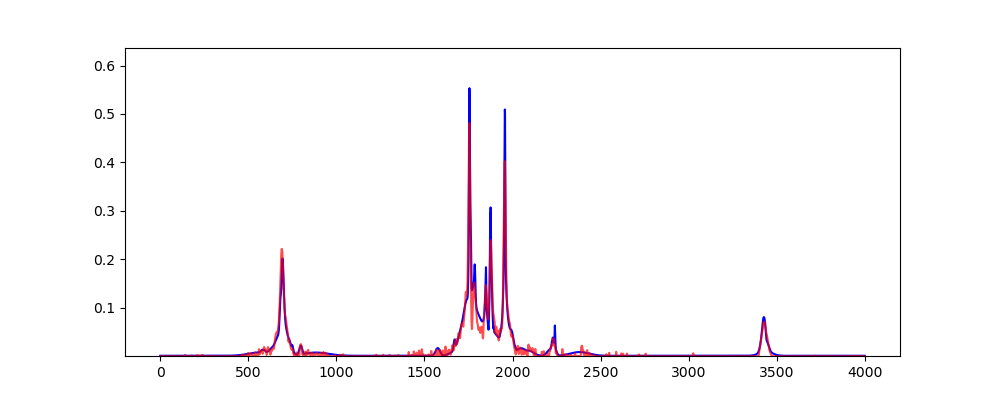

y_kde.shape =  (4000,)
event =  9


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


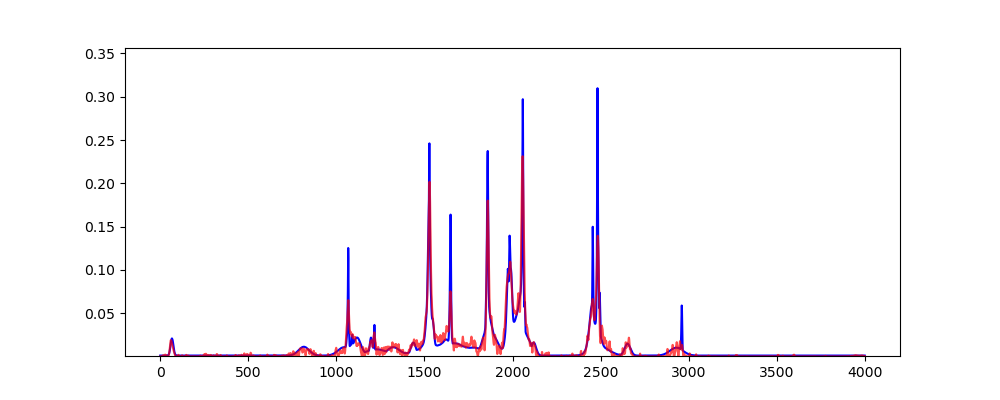

y_kde.shape =  (4000,)
event =  10


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


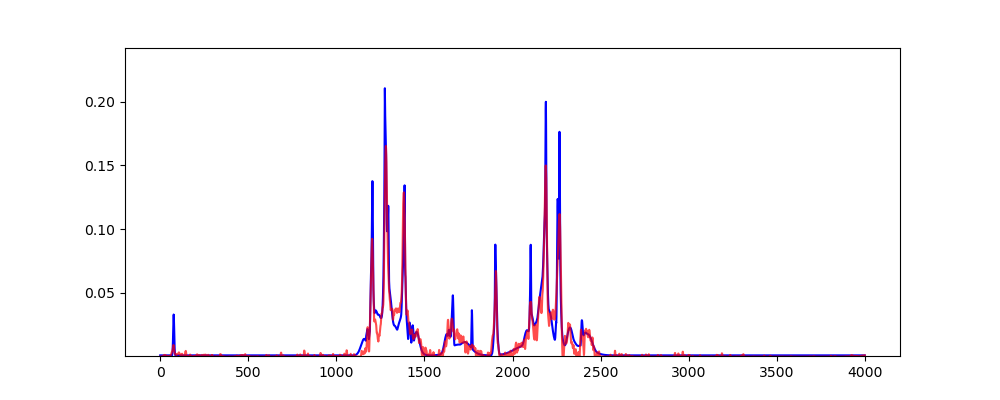

y_kde.shape =  (4000,)
event =  11


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


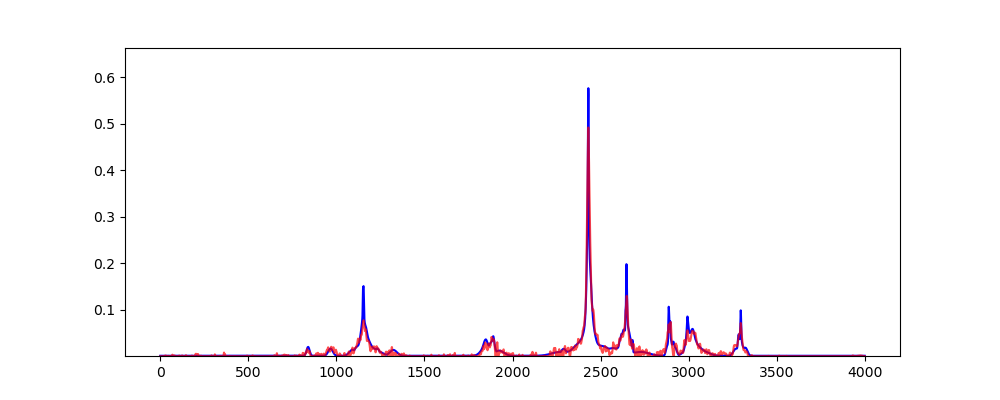

y_kde.shape =  (4000,)
event =  12


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


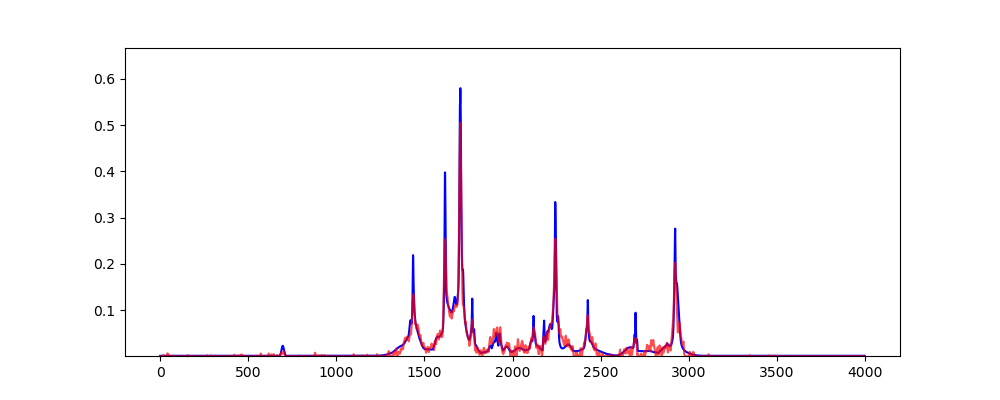

y_kde.shape =  (4000,)
event =  13


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


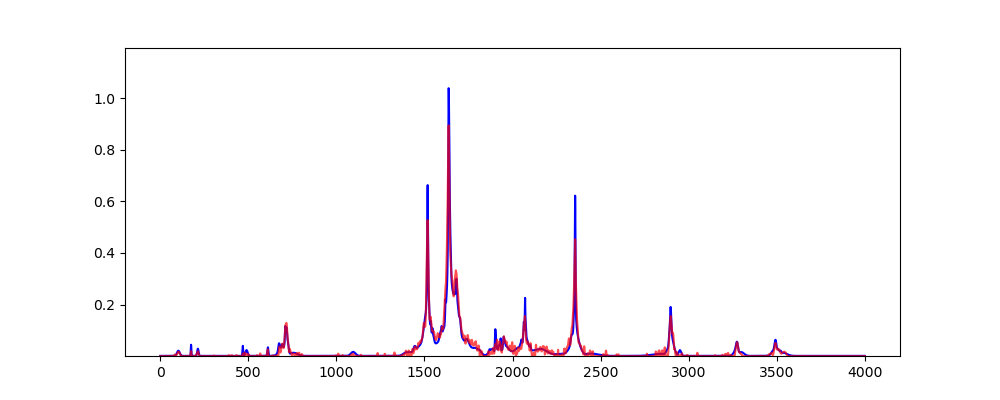

y_kde.shape =  (4000,)
event =  14


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


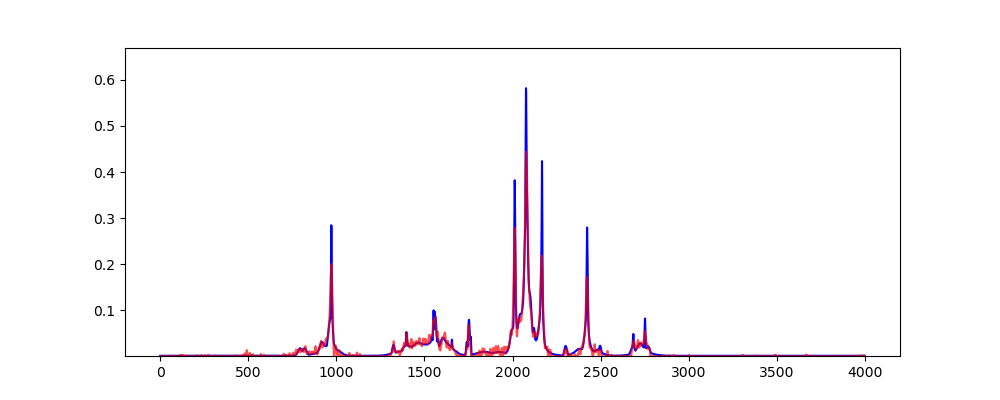

y_kde.shape =  (4000,)
event =  15


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


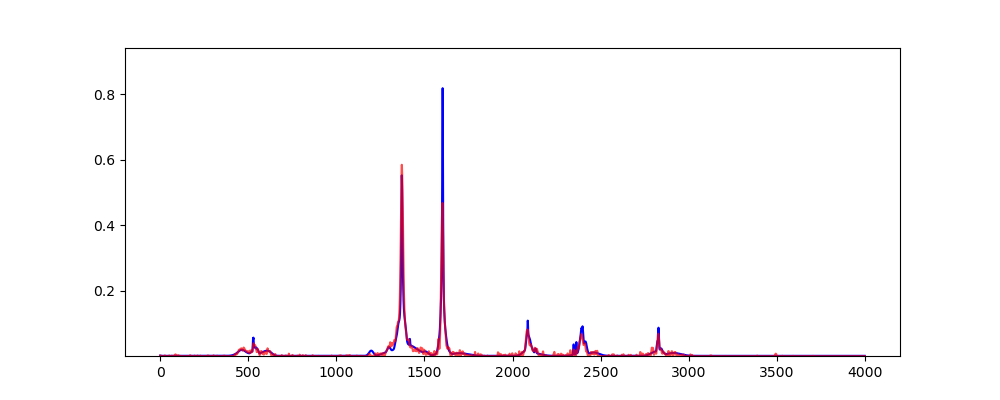

inputs.shape =  torch.Size([4, 9, 600])
outputs.shape =  torch.Size([4, 4000])
labels.shape =   torch.Size([4, 12000])
y.shape =  torch.Size([4, 4000, 3])
y_kde.shape =  (4000,)
event =  16


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


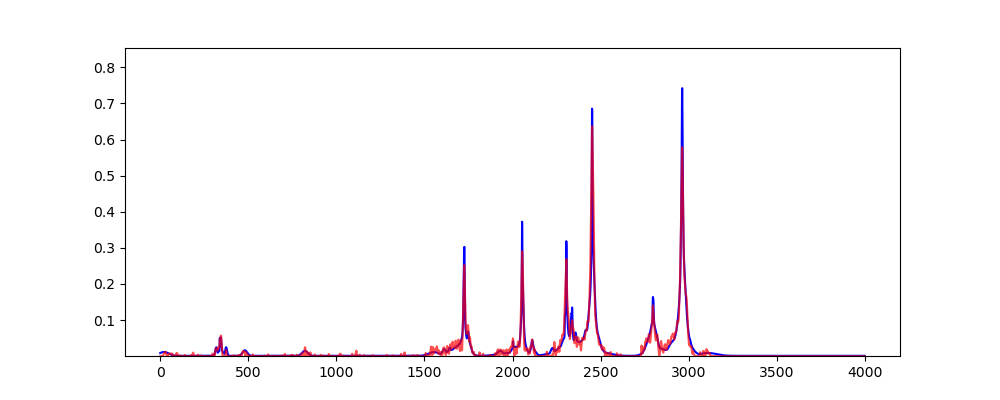

y_kde.shape =  (4000,)
event =  17


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


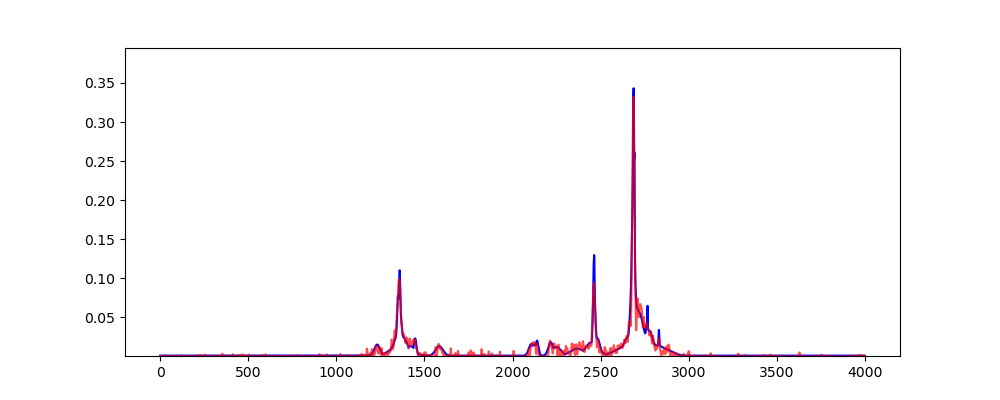

y_kde.shape =  (4000,)
event =  18


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


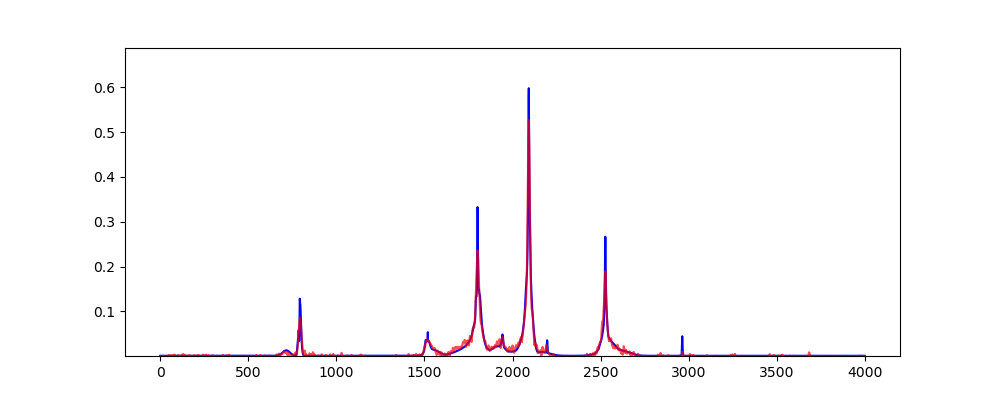

y_kde.shape =  (4000,)
event =  19


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


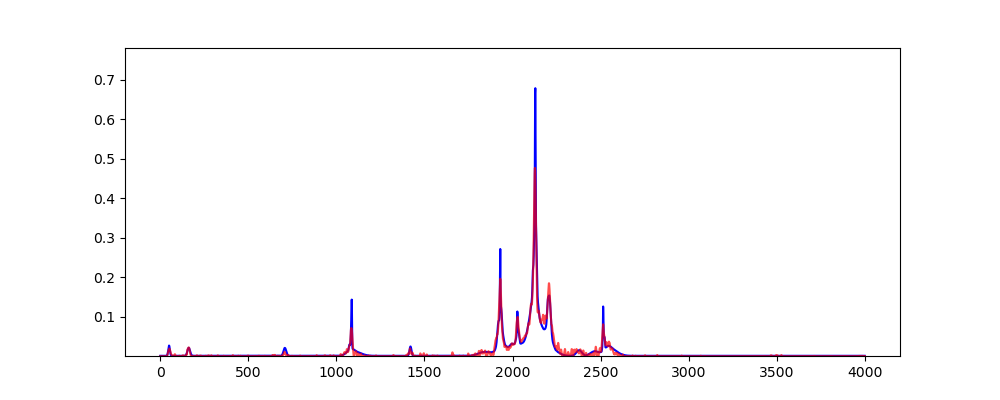

"           \n            for x,y,z,n,cat in zip(PV.x[event], PV.y[event], PV.z[event], PV.n[event], PV.cat[event]):\n                # Only print out if z in plotting range\n                if (event<11):\n                    print()\n                    print(f'PV: {n} tracks (type {cat})')\n                    print(f'  x: {x*1000:5.0f} μm')\n                    print(f'  y: {y*1000:5.0f} μm')\n                    print(f'  z: {z:8.3f} mm')\n"

In [22]:
with torch.no_grad():
    counter = 0
    event = 0
    print("val_loader = ",val_loader)
    for inputs, labels in val_loader:
##        print("counter = ",counter)
##        print("inputs = ",inputs)
        print("inputs.shape = ",inputs.shape)
        if inputs.device != device:
            inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = model(inputs)
##        print("outputs.shape = ",outputs.shape)
        nEvts = outputs.shape[0]
        print("outputs.shape = ", outputs.shape)
        print("labels.shape =  ",labels.shape)
        
        costs = loss(outputs,labels)

    
    
        nFeatures = 4000
        y = labels.view(nEvts,-1,nFeatures)
        y = y.transpose(1,2)
        
       
        print("y.shape = ",y.shape)
        for iEvt in range(nEvts):
            
            y_pred = outputs[iEvt,:]
        
            
            y_pred = y_pred.cpu().numpy()
            
            y_kde = y[iEvt,:,0].cpu().numpy()
            # Compute the "actual" efficenies and things
            print("y_kde.shape = ",y_kde.shape)
            
            
            print("event = ",event)
            if (event<20):
                plt.figure()
##                plt.yscale('log')
                plt.ylim(0.0005,1.15*max(y_kde))
                plt.plot(y_kde, color="b")
                plt.plot(y_pred, color='r', alpha = 0.7)
                plt.show()
            event = event +1
"""           
            for x,y,z,n,cat in zip(PV.x[event], PV.y[event], PV.z[event], PV.n[event], PV.cat[event]):
                # Only print out if z in plotting range
                if (event<11):
                    print()
                    print(f'PV: {n} tracks (type {cat})')
                    print(f'  x: {x*1000:5.0f} μm')
                    print(f'  y: {y*1000:5.0f} μm')
                    print(f'  z: {z:8.3f} mm')
"""




                
                
                
                
##                print("  point AA ")
## mds                features = inputs[iEvt,:]
## mds                features = features[np.newaxis,:,:]
                
                
## mds                print("features.shape = ",features.shape)
                
## mds                output_A = model(features)
## mds                y_prime = output_A[0,:]
## mds                y_prime = y_prime.cpu().numpy()
## mds                plt.figure()
## mds                plt.plot(y_prime[:], color="r")
## mds                plt.show()
                
            

##        print("nEvts = ",nEvts)
        
##        counter = counter+1
        
        
        

val_loader =  <torch.utils.data.dataloader.DataLoader object at 0x7f832bd79710>
outputs.shape =  torch.Size([20, 4000])
 =  tensor([[3.0150e-17, 1.5512e-15, 1.0885e-13,  ..., 9.3167e-04, 9.8589e-04,
         1.0406e-03],
        [3.7095e-04, 4.9212e-04, 5.4708e-04,  ..., 1.1389e-03, 1.1635e-03,
         1.1880e-03],
        [3.2732e-04, 3.6984e-04, 4.6456e-04,  ..., 1.0757e-03, 1.0995e-03,
         1.1236e-03],
        ...,
        [1.3979e-08, 1.9543e-07, 2.0951e-06,  ..., 1.6222e-04, 1.5745e-04,
         1.5220e-04],
        [1.2783e-13, 1.7795e-12, 7.4768e-11,  ..., 3.0075e-04, 3.7863e-04,
         4.5687e-04],
        [1.9073e-12, 4.6730e-10, 5.6137e-08,  ..., 1.0604e-03, 1.1339e-03,
         1.2075e-03]])
nEvts =  20
y.shape =  torch.Size([20, 4000, 3])
iEvt =  0
good_pvs =  [(-29.881668, 1, 24), (-0.15807877, 1, 10), (61.021088, 1, 26), (79.19783, 1, 19), (97.82085, 1, 24), (134.26784, 1, 7)]
good_pv_bins =  [701.0, 998.0, 1610.0, 1791.0, 1978.0, 2342.0]


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


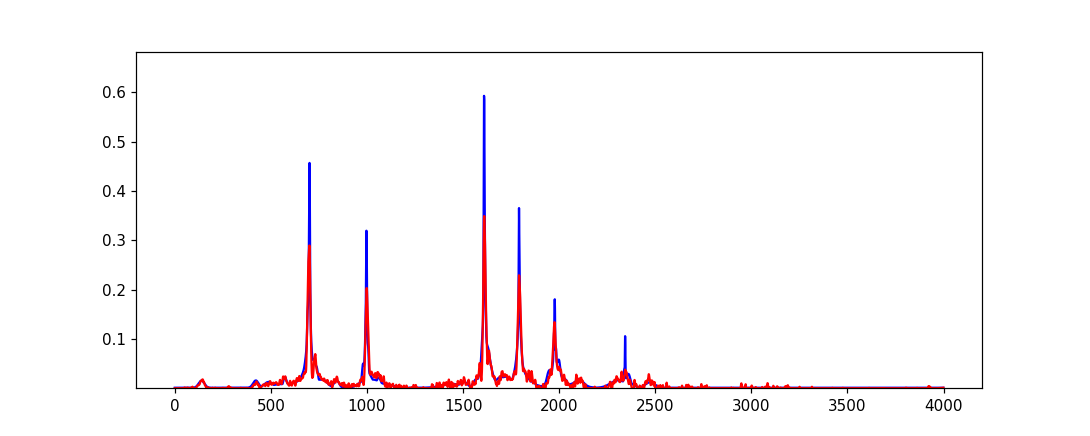

PV position and bin # =  (-29.881668, 1, 24) 701.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


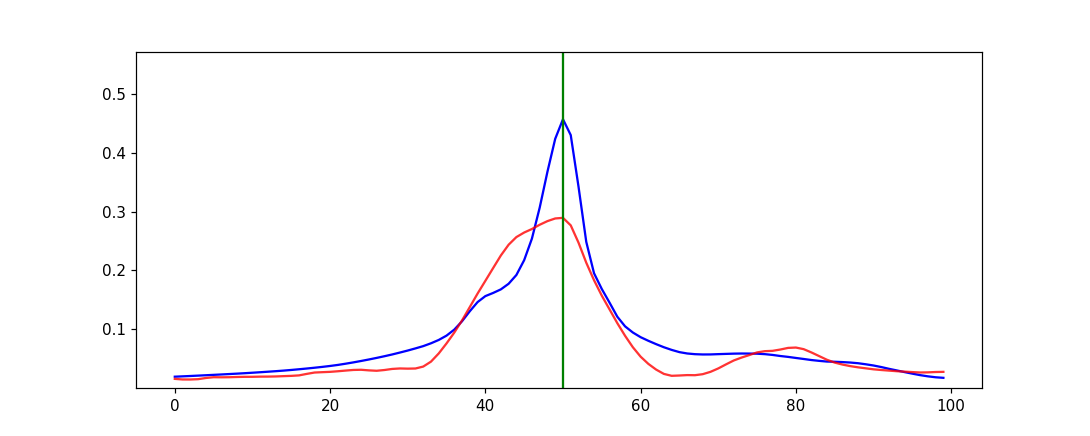

PV position and bin # =  (-0.15807877, 1, 10) 998.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


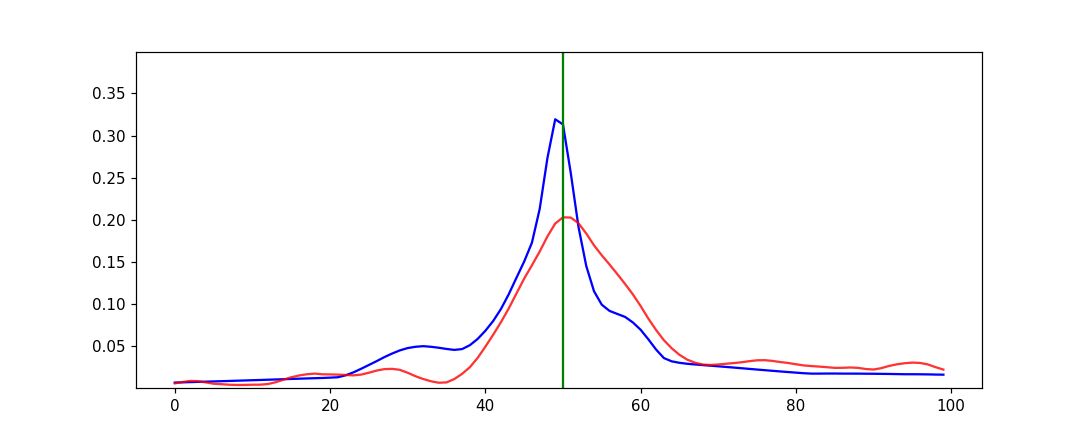

PV position and bin # =  (61.021088, 1, 26) 1610.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


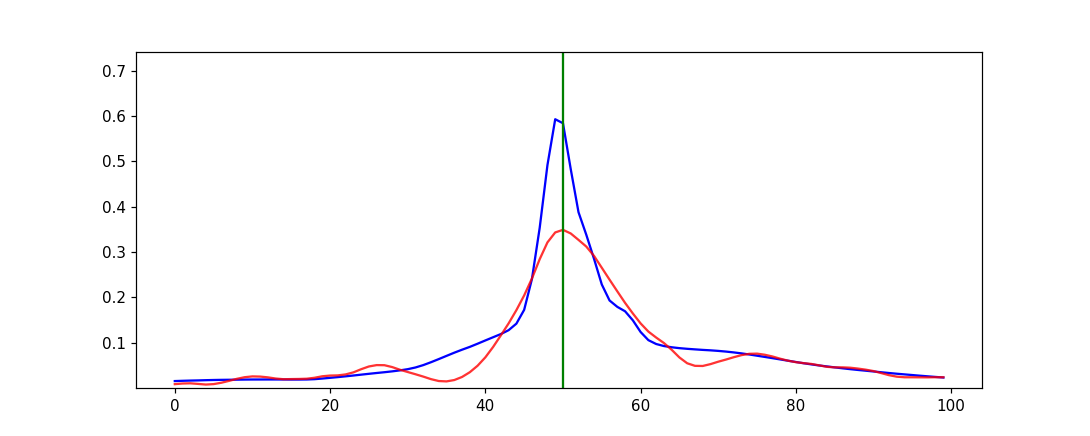

PV position and bin # =  (79.19783, 1, 19) 1791.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


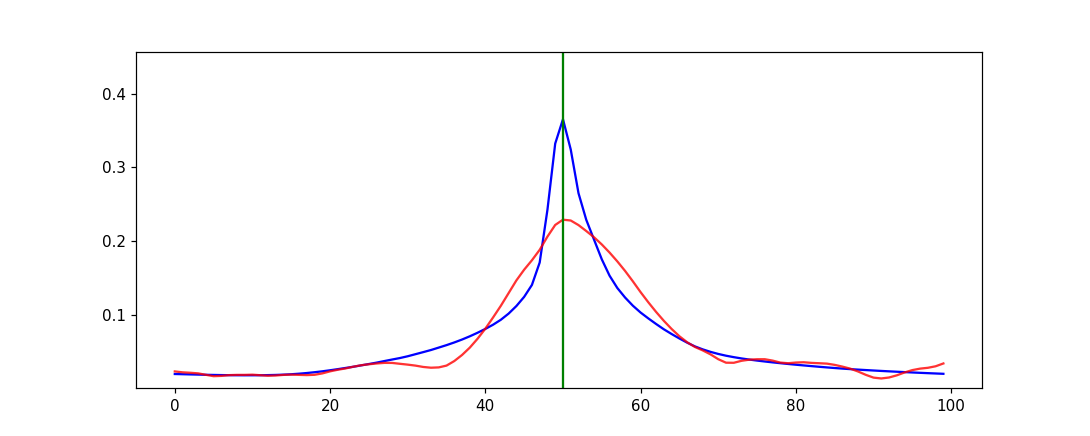

PV position and bin # =  (97.82085, 1, 24) 1978.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


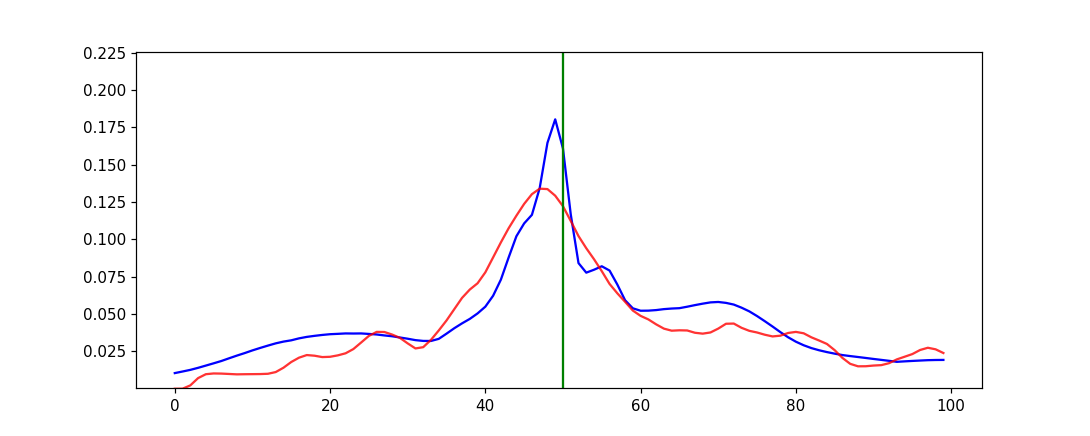

PV position and bin # =  (134.26784, 1, 7) 2342.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


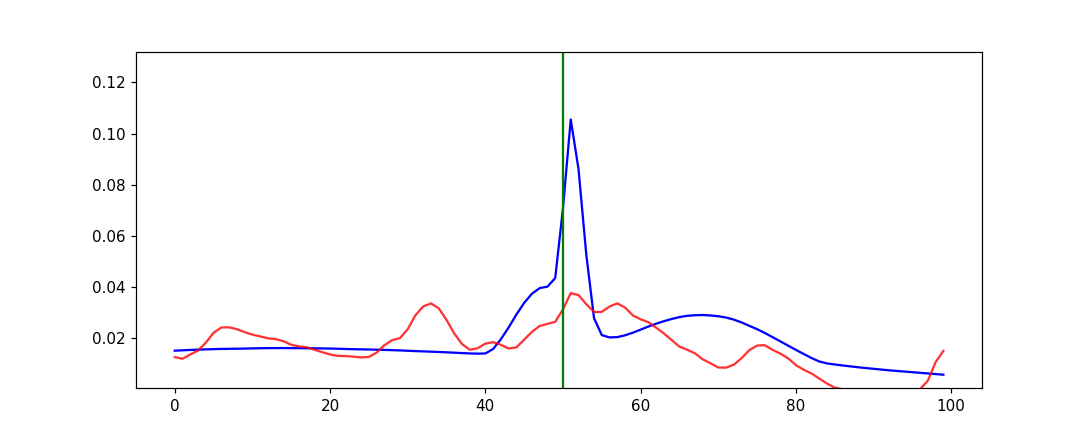

iEvt =  1
good_pvs =  [(119.57261, 1, 7)]
good_pv_bins =  [2195.0]


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


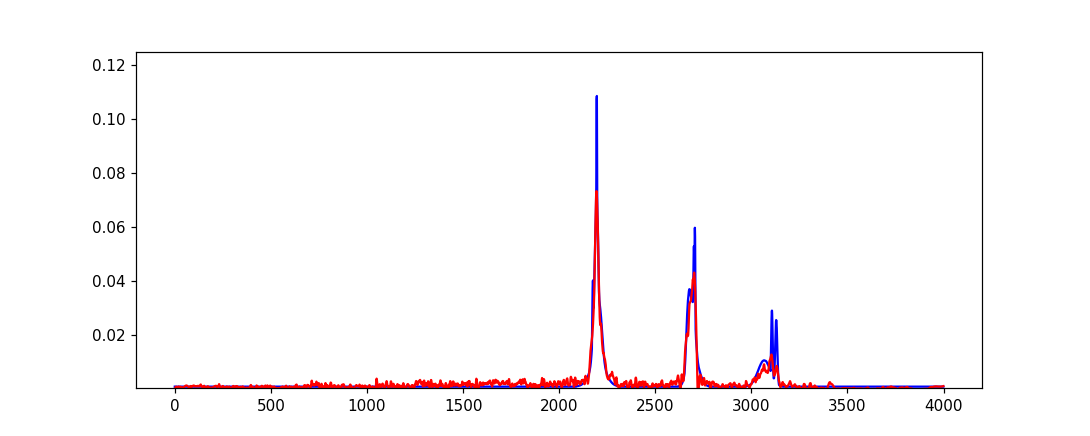

PV position and bin # =  (119.57261, 1, 7) 2195.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


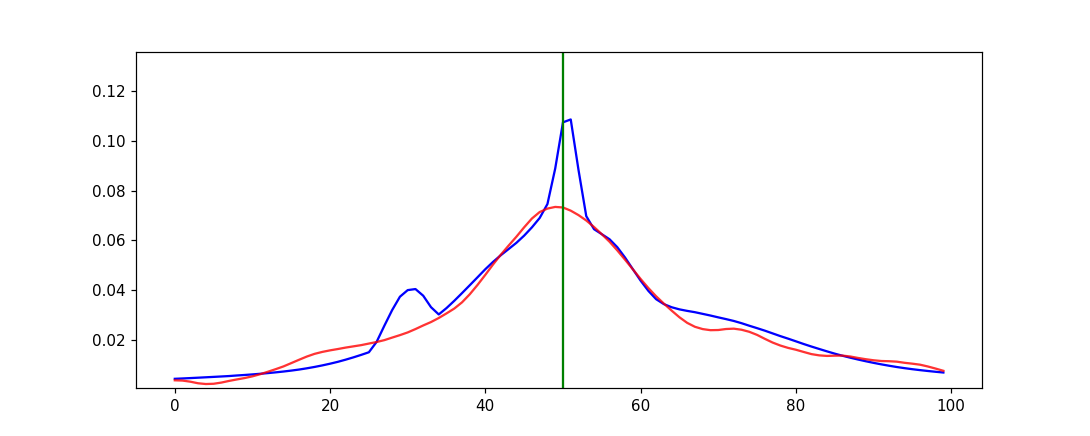

iEvt =  2
good_pvs =  [(116.2301, 1, 5), (137.23302, 1, 7)]
good_pv_bins =  [2162.0, 2372.0]


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


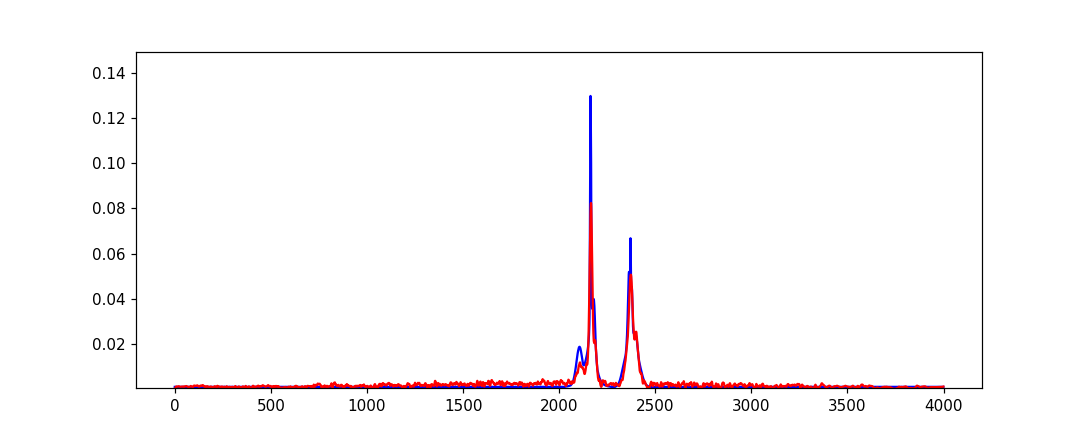

PV position and bin # =  (116.2301, 1, 5) 2162.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


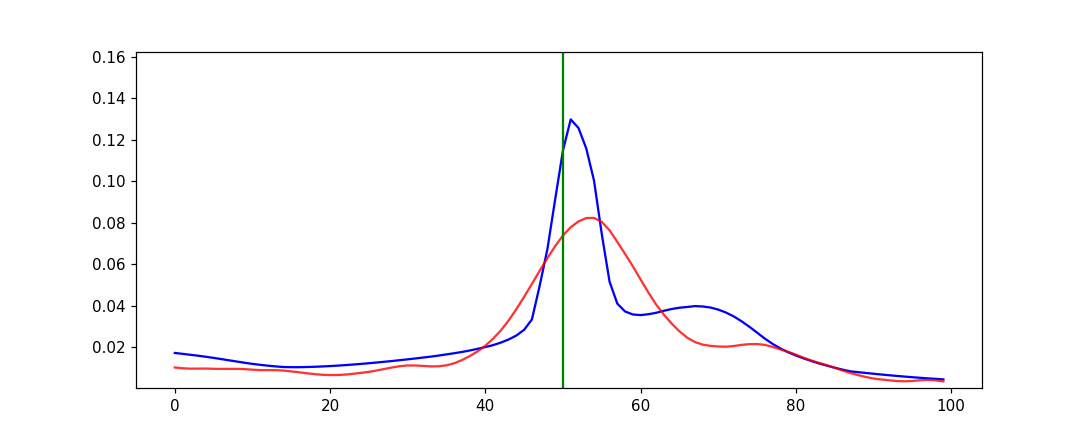

PV position and bin # =  (137.23302, 1, 7) 2372.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


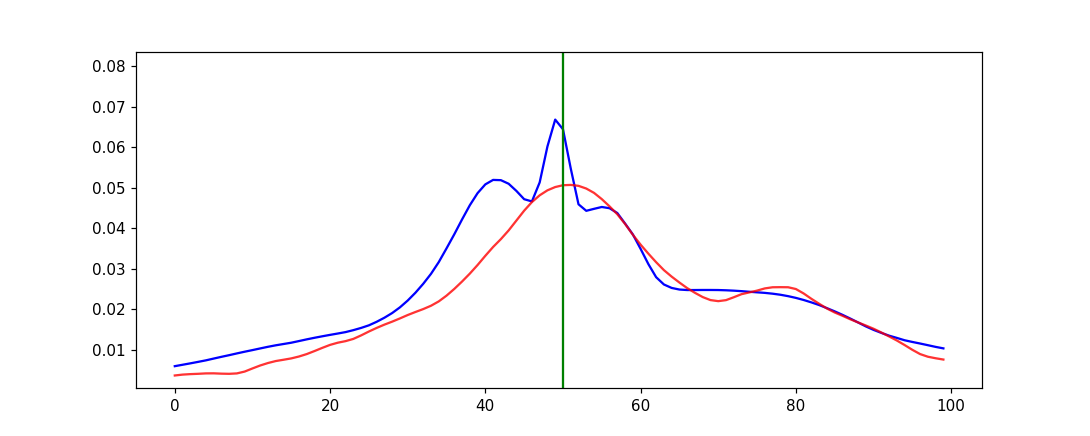

iEvt =  3
good_pvs =  [(-9.917648, 1, 25), (63.546913, 1, 28), (85.381065, 1, 13), (156.8066, 1, 42), (239.98242, 1, 11)]
good_pv_bins =  [900.0, 1635.0, 1853.0, 2568.0, 3399.0]


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


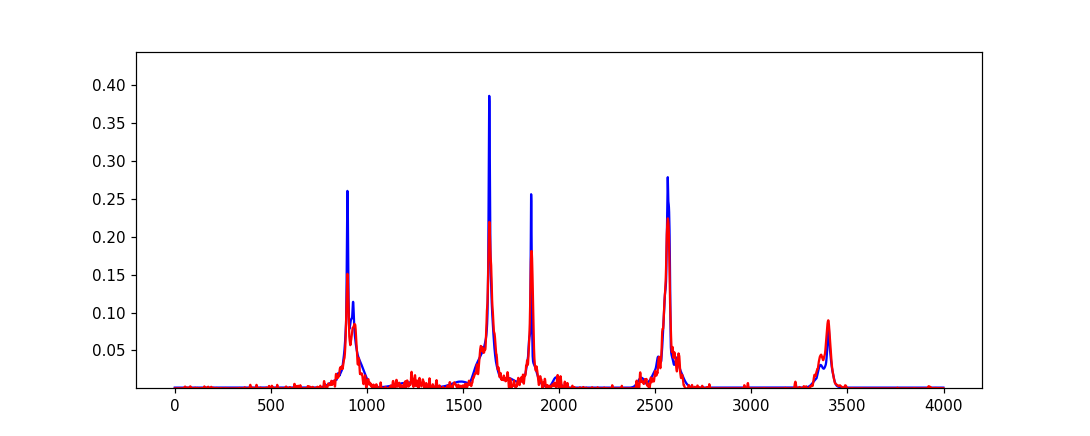

PV position and bin # =  (-9.917648, 1, 25) 900.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


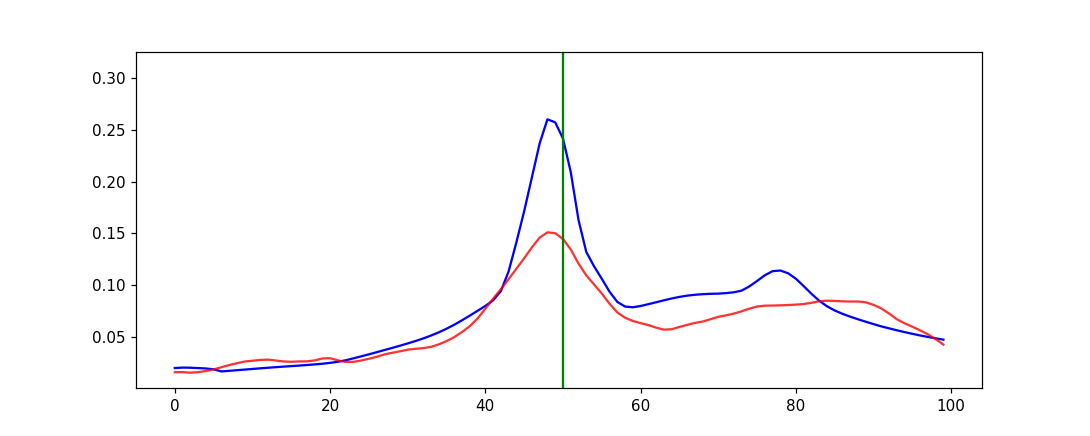

PV position and bin # =  (63.546913, 1, 28) 1635.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


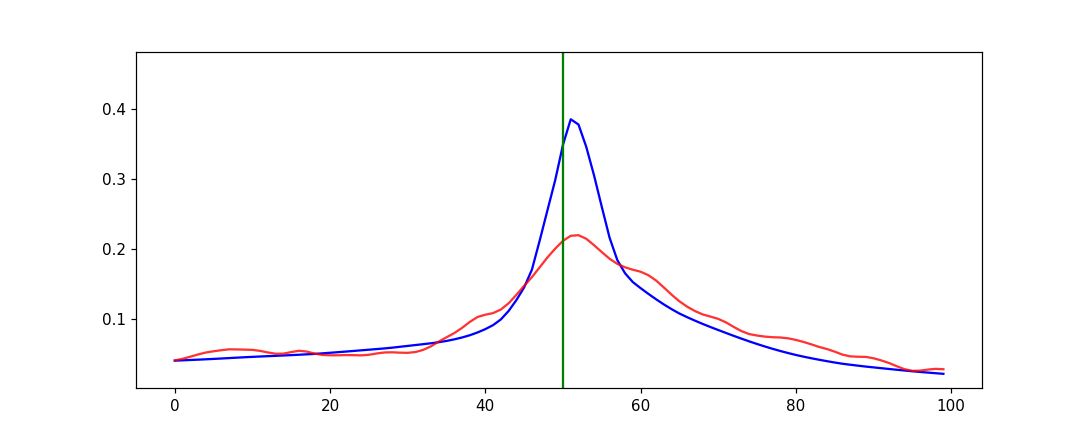

PV position and bin # =  (85.381065, 1, 13) 1853.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


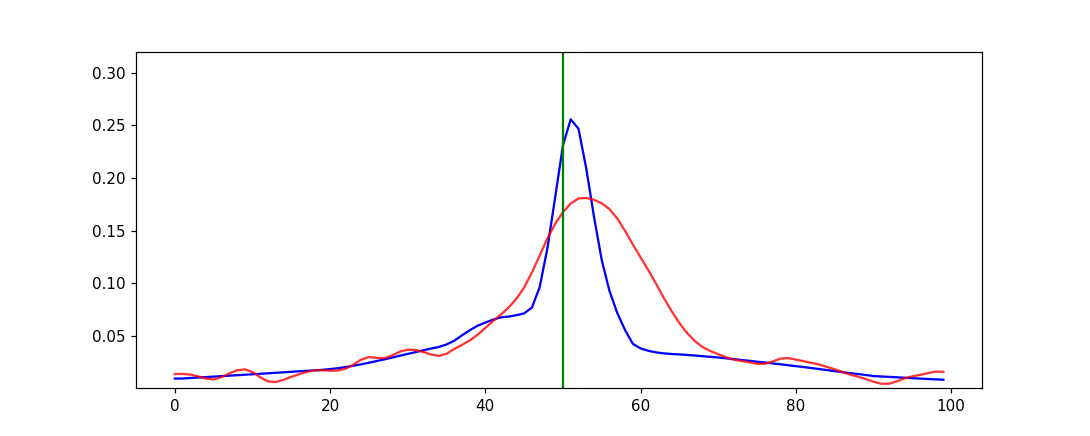

PV position and bin # =  (156.8066, 1, 42) 2568.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


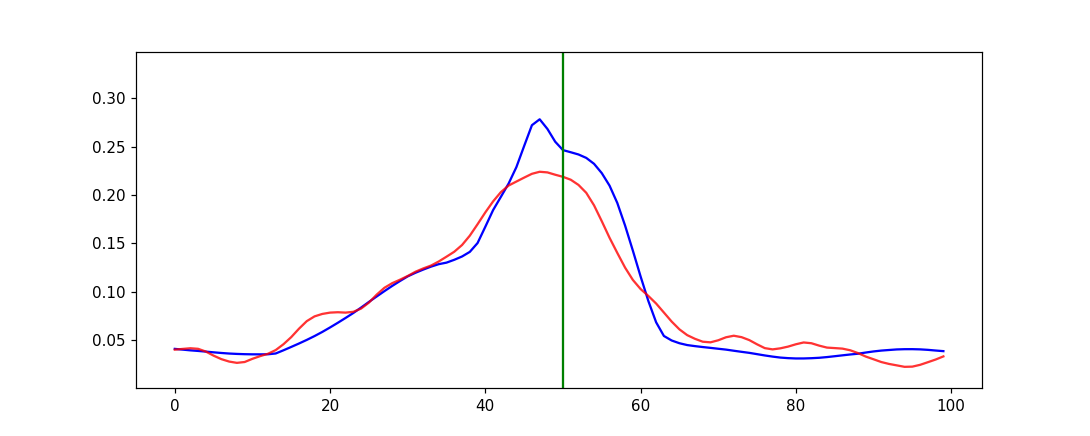

PV position and bin # =  (239.98242, 1, 11) 3399.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


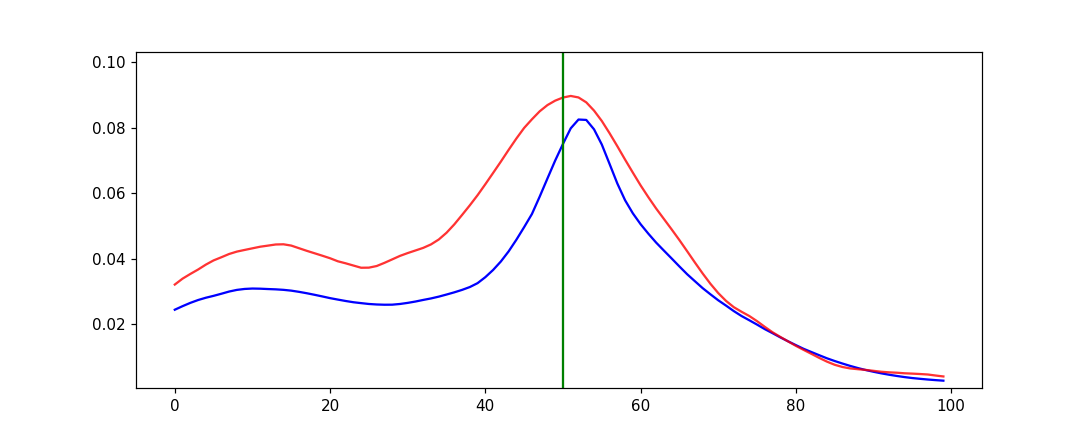

iEvt =  4
good_pvs =  [(26.315554, 1, 7), (85.32848, 1, 17), (132.24886, 1, 7), (151.79068, 1, 22), (186.51968, 1, 24), (262.89627, 1, 23)]
good_pv_bins =  [1263.0, 1853.0, 2322.0, 2517.0, 2865.0, 3628.0]


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


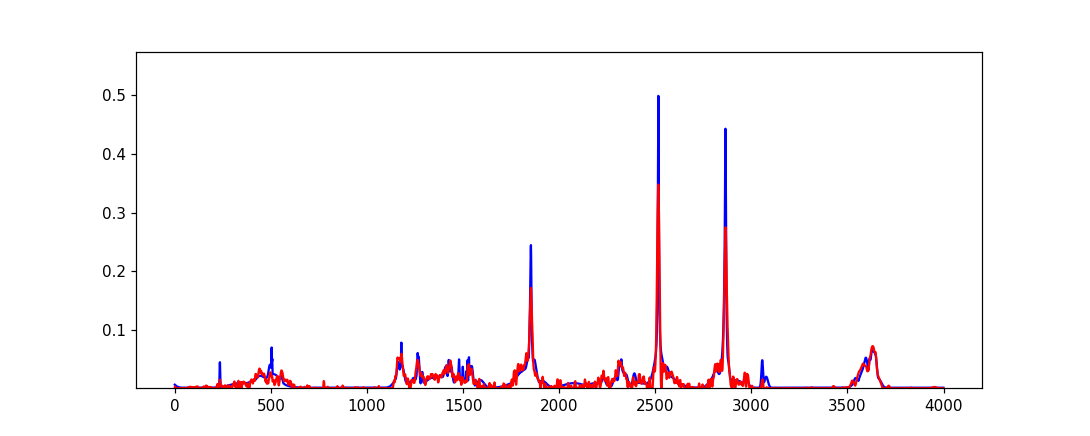

PV position and bin # =  (26.315554, 1, 7) 1263.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


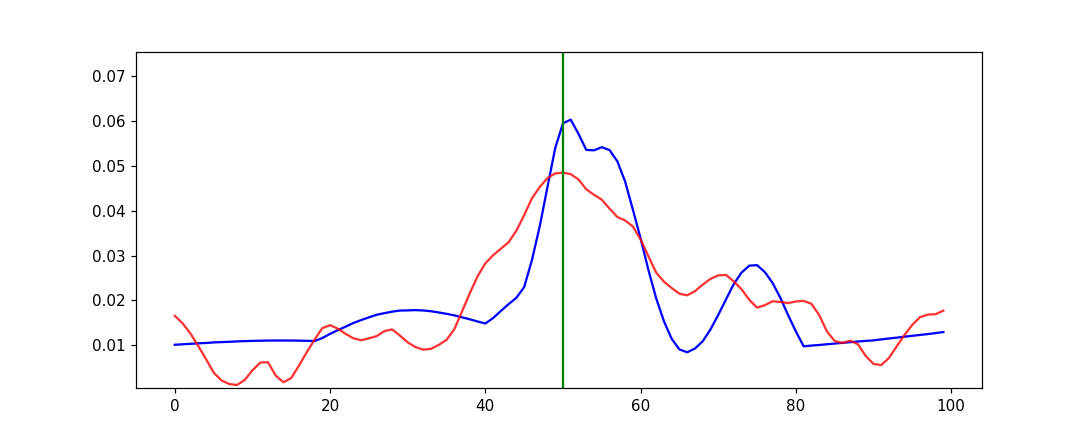

PV position and bin # =  (85.32848, 1, 17) 1853.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


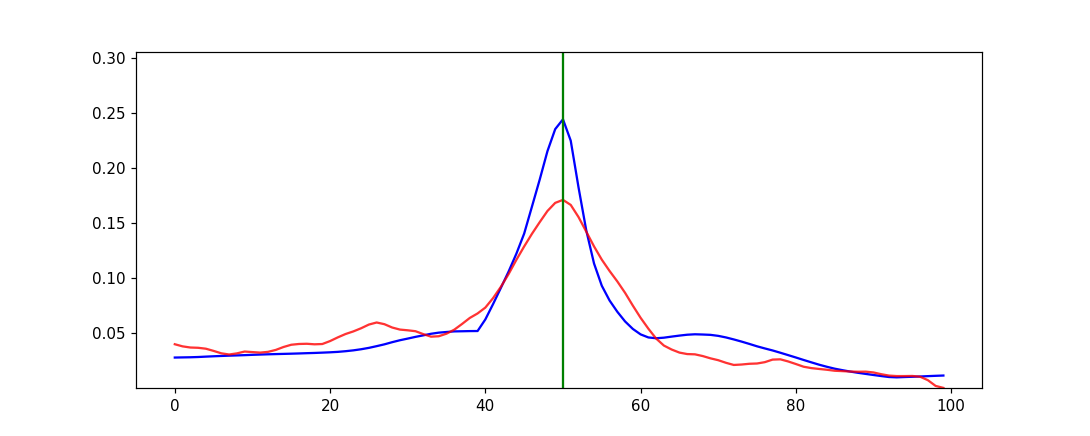

PV position and bin # =  (132.24886, 1, 7) 2322.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


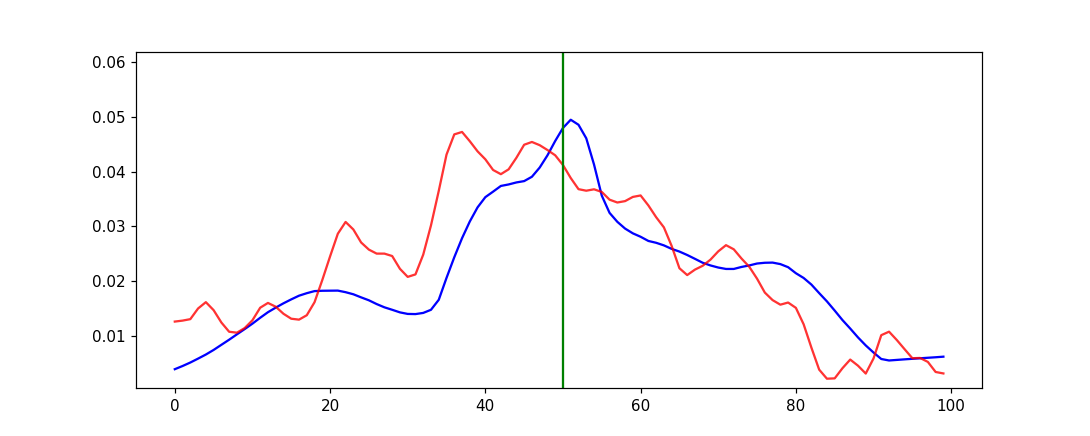

PV position and bin # =  (151.79068, 1, 22) 2517.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


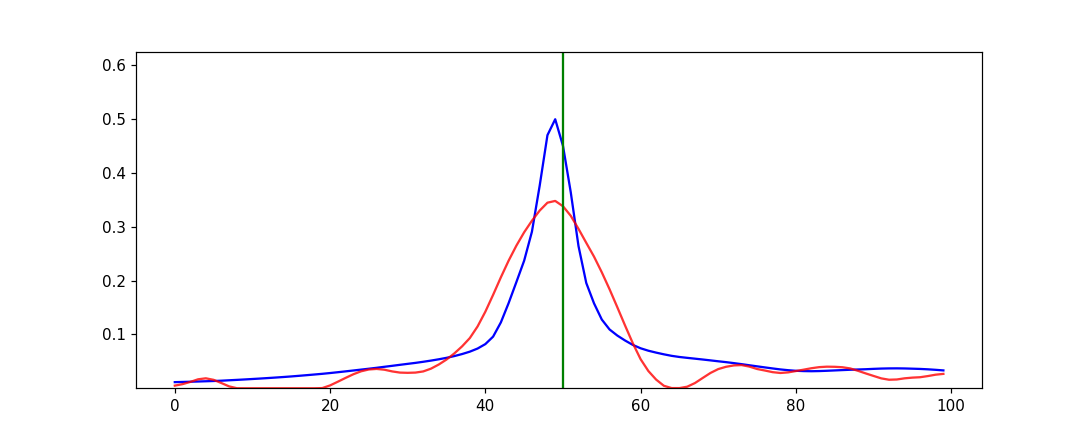

PV position and bin # =  (186.51968, 1, 24) 2865.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


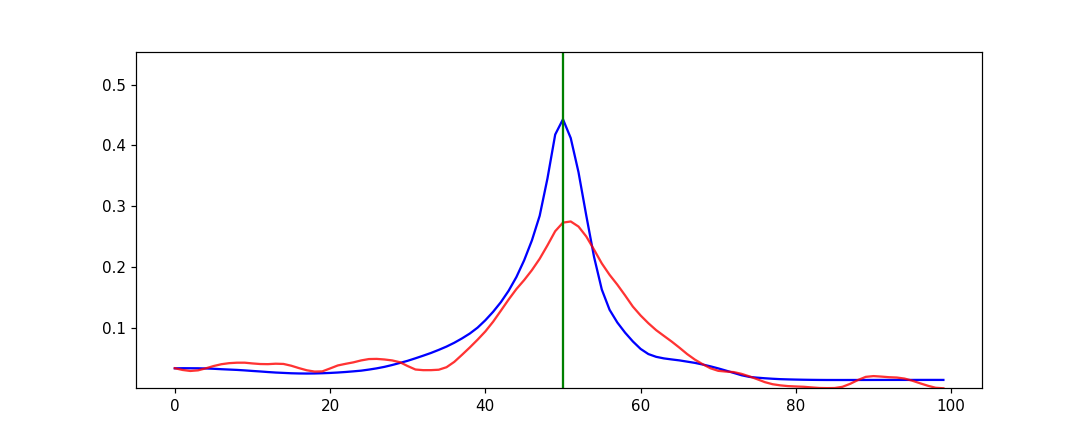

PV position and bin # =  (262.89627, 1, 23) 3628.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


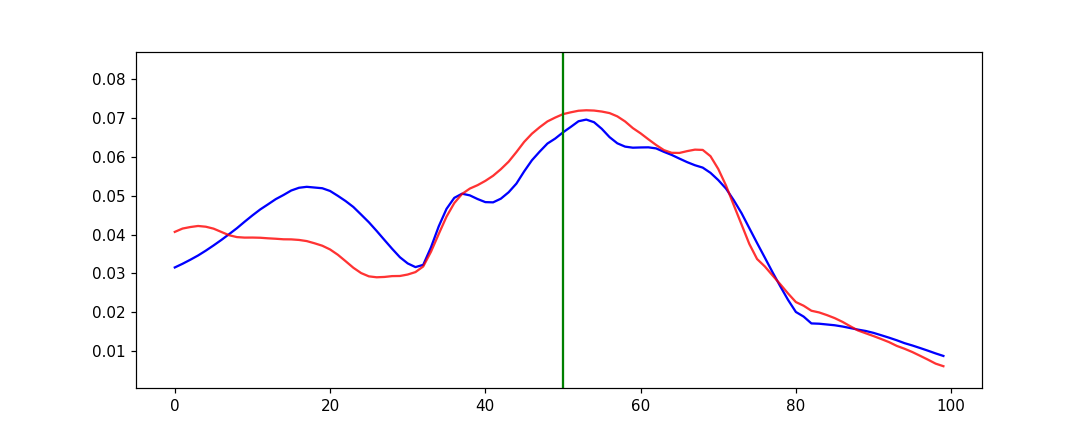

In [18]:
nFeatures = 4000
with torch.no_grad():
    print("val_loader = ",val_loader)
    outputs = model(val_loader.dataset.tensors[0])
    print("outputs.shape = ",outputs.shape)
    print(' = ',outputs)
    nEvts = outputs.shape[0]
    print("nEvts = ",nEvts)
    labels = val_loader.dataset.tensors[1]
    y = labels.view(nEvts,-1,nFeatures)
    y = y.transpose(1,2)
    print("y.shape = ",y.shape)
    
    
##    for iEvt in range(nEvts):
    for iEvt in range(5):
        print("iEvt = ",iEvt)
        y_kde = y[iEvt,:,0].cpu().numpy()
##        print("len(y_kde) = ",len(y_kde))
        
        y_pred = outputs[iEvt,:].cpu().numpy()
##        print("len(y_pred) = ",len(y_pred))
        
##        print("PV.z[iEvt]   = ", PV.z[iEvt])
##        print("PV.cat[iEvt] = ", PV.cat[iEvt])
##        print("PV.n[iEvt]   = ", PV.n[iEvt])
        
        pv_sorted = sorted(zip(PV.z[iEvt],PV.cat[iEvt],PV.n[iEvt]), key=lambda x: x[0])
##        print("pv_sorted = ",pv_sorted)
##        print("len(pv_sorted) = ",len(pv_sorted))
        good_pvs = []
        good_pv_bins = []
        for ii in range(len(pv_sorted)):
##            print("ii = ",ii)
##            print(pv_sorted[ii])
##            print(pv_sorted[ii][1])
            good = (1 == pv_sorted[ii][1])
##            print("good = ",good)
            if (good):
                good_pvs.append(pv_sorted[ii])
                good_pv_bins.append(np.floor(10.*(pv_sorted[ii][0]+100)))
        print("good_pvs = ",good_pvs)
        print("good_pv_bins = ", good_pv_bins)
        
      
        
        plt.figure()
##      plt.yscale('log')
        plt.ylim(0.0005,1.15*max(y_kde))
        plt.plot(y_kde, color="b")
        plt.plot(y_pred, color='r')
        plt.show()

   

     
        nPlots = len(good_pv_bins)
        for jj in range(nPlots):
            print("PV position and bin # = ", good_pvs[jj], good_pv_bins[jj])
            nLow =  int(good_pv_bins[jj]-50)
            nHigh = int(good_pv_bins[jj]+50)
            plt.figure()
            plt.ylim(0.0005,1.25*max(y_kde[nLow:nHigh]))
##            plt.yscale('log')
            plt.plot(y_kde[nLow:nHigh], color="b")
            plt.plot(y_pred[nLow:nHigh], color='r', alpha = 0.8)
            plt.axvline(x=50, color='g')
            plt.show()
          

Go ahead and save the final model (even though it was also saved above):

Save the output results: